# Create wave flume

In [1]:
import sys;sys.path.append('../xbeach/')
from importlib import reload
from libs import *
from scipy.io import loadmat
import xbeach
import utils
from datetime import datetime,timedelta

### Initialize Octave Engine and add xbeach matlab library

In [2]:
root = pl.Path(r'Z:\Users\Tyler\projects\flume')
#octave.addpath(r'Z:\Users\Tyler\other\xbeach_release_10May2013');
#octave.addpathfast(r'Z:\Users\Tyler\other\xbeach_release_10May2013');
#octave.run('oetsettings.m');

### Add paths

In [2]:
from importlib import reload
import utils
reload(utils)
from utils import *

ModuleNotFoundError: No module named 'utils'

In [4]:
field = pl.Path(r'Z:\Project_TNC\3_Field\2_Data\2_Processed')
water = hobo(str(field / '1_hobo' / 'di_20180912_20181205' / 't1_v2.mat'))
waves = trublues(str(field / '2_trublue' / 'di_20180912' / 'after_juan' / 't1s1.mat'))
#adcp = adcp(str(field / '2_trublue' / 'di_20180912' / 'after_juan' /'adcp1.mat'))
flume = pd.read_csv(str(root / 'flume_xs.csv'))
x = np.array(np.round(flume['x'],6))
z = np.array(np.round(flume['z'],6))
z3 = np.array(np.round(flume['z3'],6))
z4 = np.array(np.round(flume['z4'],6))
layer = np.array(np.round(flume['layer'],6))

### Creating a non-erodible layer file

In [39]:
layer = []
for i in range(0,90):
    if 32<i<38:
        layer.append(0)
    else:
        layer.append(1)
layer = np.array(layer)

### Plot Pre Cross Section

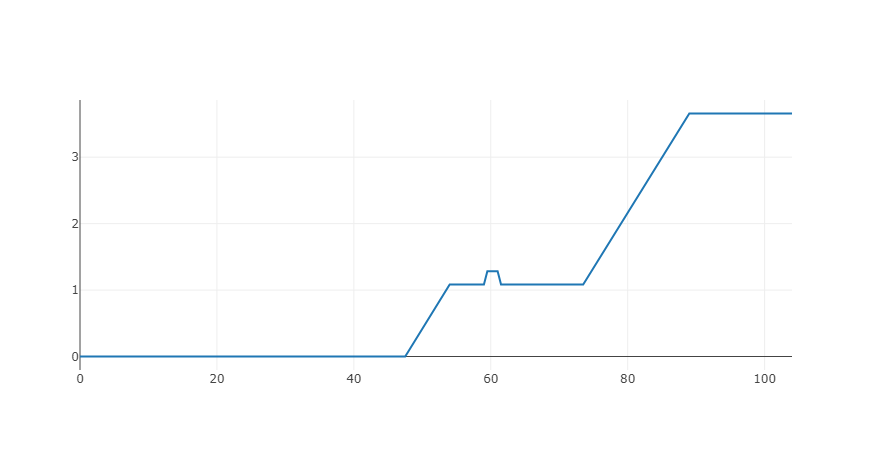

In [11]:
trace = go.Scatter(
    x = x,
    y = z4)
data = [trace]
iplot(data)

### Generate the Topo/Bathy Cross Section

In [9]:
bedfrict = z*0+0.2
dxmin = 0.5
#data = octave.xb_grid_xgrid(x.tolist(),z.tolist(),'dxmin',dxmin)
bathy = octave.xb_generate_bathy('x',x.tolist(),'z',z2.tolist(),'ne',layer) # This doesn't always generate x.grd file

### Generate Waves

In [10]:
wave = octave.xb_generate_waves('Hm0',waves['h0'],'Tp',waves['Tp'],'duration',1200.0,'mainang',90.0,'gammajsp',3.3,'s',10.0,'fnyq',0.45)

In [11]:
duration = 1200
path = root / 'xbeach' / 'test6'
write_waves(str(path),waves['h0']+0.25,waves['Tp'],duration,604800)

### Create Vege Map

In [4]:
path = r'Z:\Users\Tyler\projects\TNC\modeling\final_grid2'
utils.write_vege_map(path,'deal+channel.dep')

In [7]:
def write_zinit(path:str,bathy_file:str,fname:str='zinit.txt',elevation:float=0):
    path = pl.Path(path)
    with open(str(path / bathy_file),'r+') as fin:
        with open(str(path / fname),'w+') as fout:
            lines = fin.readlines()
            for line in lines:
                data = line.strip().split('  ')
                for i in range(0,len(data)):
                   # print(data)
                    vege = []
                    new = []
                    if data != '':            
                        if float(data[i]) > elevation:
                            fout.write('   '+str(0))
                        else:
                            fout.write('   '+str(float(data[i])+0.2))
                fout.write('\n')
    return

In [8]:
path = r'Z:\Users\Tyler\projects\TNC\modeling\final_grid2'
write_zinit(path,'deal+channel.dep')

### Generate Tidal Forcing

In [12]:
time = np.arange(0,43200,360)
wl =  1+np.sin(time*(0.83333))#for i in range(0,time[-1],360)] 

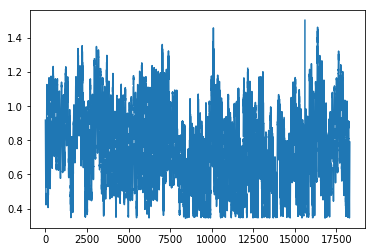

In [17]:
plt.plot(water.index.values,water['water level (m) NAVD88'])

In [9]:
water = water.reset_index().dropna()

In [36]:
water['water level (m) NAVD88'].astype('float').values-.25

array([0.667994, 0.665994, 0.639994, ..., 0.481994, 0.505994, 0.539994])

In [ ]:
path = root / 'xbeach' / 'test6'

In [5]:
path = pl.Path(r'Z:\Users\Tyler\projects\TNC\modeling\2d\april12_inputs')
write_tide(path,water.index.values*360,water['water level (m) NAVD88'].astype('float').values
           ,water['water level (m) NAVD88'].astype('float').values)

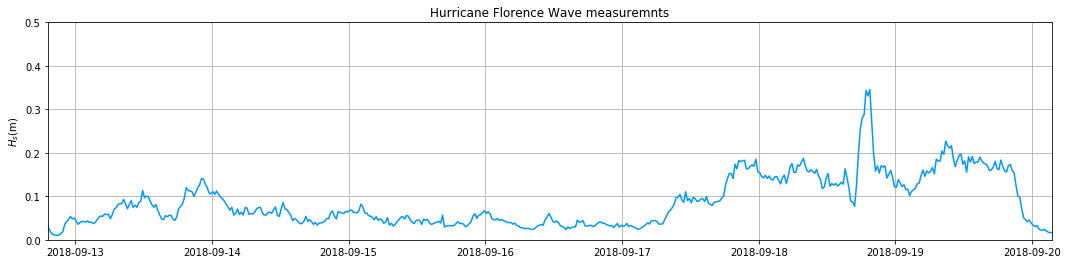

In [15]:
fig,ax = plt.subplots(figsize=(18,4))

ax.plot(waves['datetime'],waves['h0'],color='#0099ff')
ax.set_xlim([waves['datetime'].iloc[0],waves['datetime'].iloc[-1]])
ax.set_ylim([0,0.5])
ax.grid(True)
ax.set_ylabel('$H_{s}$(m)')
ax.set_title('Hurricane Florence Wave measuremnts')
plt.savefig('t1_waves.png',dpi=300,bbox_inches = 'tight', pad_inches = 0.1)


### Generate Settings

In [20]:
xb_set=octave.xb_generate_settings('outputformat','netcdf','nx',str(len(x)-1),'ny',0.0,'depfile','bed.dep',
        'vardx',1.0,'thetamin',0.0,'thetamax',180.0,'dtheta',180.0,'dtheta_s',5.0,'xori',0.0,'dx',0.5,
        'xfile','x.grd','bcfile','filelist.txt','instat','jons','morfac', 1.0,'posdwn',-1.0,'avalanching',0.0,
        'morstart', 0.0,'CFL', 0.7,'front', 'waveflume','random',0.0,'taper',10.0,'zs0file','tide.txt','tideloc',2.0,
        'back', 'abs1d','left','wall','right','wall','mpiboundary','auto','morfacopt',0.0,'struct',1.0,
        'ne_layer','nebed.dep','thetanaut', 1.0,'zs0',0.0,'single_dir',0.0,'tstop', 43200.0,'tstart', 0.0,
        'tint', 604800.0,'tintm',360.0,'tintg',604800.0,'epsi',-1.0,'facua',0.30,
        'bedfriction', 'manning','meanvar',{'zb', 'zs', 'H','u','v','structdepth'} ,'globalvar',{'zb', 'zs','H','u','v'});

### Join all parameters and write inputs

In [13]:
#np.savetxt(str(root / 'xbeach' / 'test6' / 'x.grd'),x.reshape(1,209),fmt='%.4e',delimiter='    ')
np.savetxt(str(root / 'xbeach' / 'no_struct' / 'bed.dep'),z3.reshape(1,209),fmt='%.4e',delimiter='    ')
#np.savetxt(str(root / 'xbeach' / 'test6' / 'nebed.dep'),layer.reshape(1,209),fmt='%.4e',delimiter='    ')

In [26]:
octave.xb_write_input(str(root / 'xbeach' / 'test6' / 'params.txt'), xb_set)

start
Here
add general
